Phase 1: Displacement

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings

# BioPython imports
from Bio.PDB import MMCIFParser, Superimposer
from Bio.PDB.Polypeptide import three_to_one
from Bio import pairwise2
from Bio.Align import substitution_matrices

# --- Configuration ---
warnings.filterwarnings("ignore")

# --- File Paths ---
CIF_DIR = "../Data/CIF_Files/"
REP_CHAIN_FILE = "../Output/Binding_Residue/Rep_GPCR_chain.csv"
SEQUENCE_INFO_FILE = '../Input/Human_GPCR_PDB_Info.csv'
REP_APO_FILE = "../Output/Final/Representative_Apo_Structures.csv"
CLASSIFICATION_FILE = "../Output/Dynamics/GPCR_PDB_classification.csv"

OUTPUT_DIR = "../Output/Dynamics/"
DISPLACEMENT_RESULTS_FILE = os.path.join(OUTPUT_DIR, "GPCR_Residue_Displacements.csv")

In [2]:
# --- Helper Functions ---
def get_rep_chain_id(uniprot_id, pdb_id, df_rep_chain):
    """Gets the representative chain ID for a given PDB."""
    subset = df_rep_chain[(df_rep_chain['UniProt_ID'] == uniprot_id) & (df_rep_chain['PDB_ID'] == pdb_id)]
    if subset.empty: return None
    return subset.sort_values(by='score', ascending=False).iloc[0]['chain_id']

def load_and_align_structure(pdb_id, chain_id, uniprot_seq, alignment_matrix):
    """
    Loads a PDB structure, aligns it to the UniProt sequence,
    and returns a dictionary mapping {uniprot_pos: residue_object} and the Bio.PDB.Model object.
    """
    cif_path = os.path.join(CIF_DIR, f"{pdb_id.lower()}.cif")
    if not (os.path.exists(cif_path) and chain_id): return None, None
    try:
        parser = MMCIFParser(QUIET=True)
        structure = parser.get_structure(pdb_id, cif_path)
        model = structure[0]
        chain = model[chain_id]
        
        pdb_residues = [res for res in chain.get_residues() if res.id[0] == ' ' and 'CA' in res]
        pdb_seq = "".join([three_to_one(res.get_resname()) for res in pdb_residues])
        if not pdb_seq: return None, None

        alignments = pairwise2.align.localds(uniprot_seq.replace('-', ''), pdb_seq, alignment_matrix, -10, -0.5)
        if not alignments: return None
        
        aligned_uni_seq, aligned_pdb_seq, _, _, _ = alignments[0]
        
        final_map = {}
        pdb_res_idx = 0
        uni_pos_idx = 0
        for uni_char, pdb_char in zip(aligned_uni_seq, aligned_pdb_seq):
            if uni_char != '-': uni_pos_idx += 1
            if pdb_char != '-':
                if uni_char != '-': final_map[uni_pos_idx] = pdb_residues[pdb_res_idx]
                pdb_res_idx += 1
        return final_map, model
    except Exception:
        return None, None

In [3]:
def calculate_displacements():
    """
    Calculates the per-residue C-alpha displacement between a representative Apo
    structure and all corresponding Holo structures for each GPCR.
    """
    print("--- Starting Per-Residue Displacement Calculation ---")
    
    # 1. Load all necessary data
    df_class = pd.read_csv(CLASSIFICATION_FILE)
    df_rep_chain = pd.read_csv(REP_CHAIN_FILE)
    df_seq_info = pd.read_csv(SEQUENCE_INFO_FILE)
    df_rep_apo = pd.read_csv(REP_APO_FILE)
    sequence_cache = df_seq_info.set_index('Entry')['Sequence'].to_dict()
    blosum62 = substitution_matrices.load("BLOSUM62")
    
    # 2. Determine the single best representative Apo PDB for each GPCR
    df_rep_apo_filtered = df_rep_apo[df_rep_apo['Binding_Coverage'] == 100.0].copy()
    df_rep_apo_filtered.sort_values(by=['UniProt_ID', 'Resolution'], ascending=[True, True], inplace=True)
    rep_apo_map = df_rep_apo_filtered.drop_duplicates(subset=['UniProt_ID'], keep='first').set_index('UniProt_ID')['PDB_ID'].to_dict()
    
    all_displacement_data = []

    # 3. Loop through each GPCR that has a representative Apo structure
    for uniprot_id, apo_pdb_id in tqdm(rep_apo_map.items(), desc="Processing GPCRs"):
        
        uniprot_seq = sequence_cache.get(uniprot_id)
        apo_chain_id = get_rep_chain_id(uniprot_id, apo_pdb_id, df_rep_chain)
        if not uniprot_seq or not apo_chain_id: continue
            
        # Load the reference Apo structure
        apo_res_map, _ = load_and_align_structure(apo_pdb_id, apo_chain_id, uniprot_seq, blosum62)
        if not apo_res_map: continue
            
        # Get all Holo PDBs for this GPCR
        class_row = df_class[df_class['GPCR'] == uniprot_id]
        if class_row.empty: continue
        holo_pdbs = eval(class_row.iloc[0]['agonist_bound_PDBs']) + eval(class_row.iloc[0]['antagonist_bound_PDBs'])
        
        displacements_per_residue = {} # {uni_pos: [disp1, disp2, ...]}

        # 4. Loop through each Holo PDB, superimpose, and calculate displacement
        for holo_pdb_id in holo_pdbs:
            holo_chain_id = get_rep_chain_id(uniprot_id, holo_pdb_id, df_rep_chain)
            if not holo_chain_id: continue
                
            holo_res_map, holo_model = load_and_align_structure(holo_pdb_id, holo_chain_id, uniprot_seq, blosum62)
            if not holo_res_map: continue

            # Find common residues for superimposition
            common_keys = sorted(list(apo_res_map.keys() & holo_res_map.keys()))
            if len(common_keys) < 50: continue

            # Prepare atoms for Superimposer
            apo_atoms = [apo_res_map[k]['CA'] for k in common_keys]
            holo_atoms = [holo_res_map[k]['CA'] for k in common_keys]
            
            # Superimpose Holo onto Apo
            super_imposer = Superimposer()
            super_imposer.set_atoms(apo_atoms, holo_atoms)
            super_imposer.apply(holo_model.get_atoms()) # Apply transformation to the entire Holo model

            # Calculate displacement for each common residue using the transformed coordinates
            for key in common_keys:
                apo_coord = apo_res_map[key]['CA'].get_coord()
                holo_coord = holo_res_map[key]['CA'].get_coord() # These are now the transformed coordinates
                displacement = np.linalg.norm(apo_coord - holo_coord)
                
                if key not in displacements_per_residue:
                    displacements_per_residue[key] = []
                displacements_per_residue[key].append(displacement)

        # 5. Aggregate results for the GPCR (calculate median displacement)
        for uni_pos, disp_list in displacements_per_residue.items():
            median_displacement = np.median(disp_list)
            res_char = three_to_one(apo_res_map[uni_pos].get_resname())
            all_displacement_data.append({
                'UniProt_ID': uniprot_id,
                'UniProt_Position': uni_pos,
                'Amino_Acid': res_char,
                'Median_Displacement_A': median_displacement
            })
            
    # 6. Create and save the final DataFrame
    df_displacement = pd.DataFrame(all_displacement_data)
    df_displacement.to_csv(DISPLACEMENT_RESULTS_FILE, index=False)
    
    print(f"\n✅ Displacement calculation complete. Results saved to: {DISPLACEMENT_RESULTS_FILE}")
    print("\nDisplacement Data Preview:")
    print(df_displacement.head())

In [4]:
calculate_displacements()

--- Starting Per-Residue Displacement Calculation ---


Processing GPCRs: 100%|██████████| 63/63 [53:16<00:00, 50.73s/it]   


✅ Displacement calculation complete. Results saved to: ../Output/Dynamics/GPCR_Residue_Displacements.csv

Displacement Data Preview:
  UniProt_ID  UniProt_Position Amino_Acid  Median_Displacement_A
0     O15552                 4          D               2.120368
1     O15552                 5          W               1.167938
2     O15552                 6          K               1.510014
3     O15552                 7          S               1.655291
4     O15552                 8          S               1.172005


Phase 2: MSA Conservation Score

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from tqdm import tqdm

# --- File Paths ---
MSA_FILE = '../Output/Dynamics/MSA_DF.csv'
SEQUENCE_INFO_FILE = '../Input/Human_GPCR_PDB_Info.csv'

OUTPUT_DIR = "../Output/Dynamics/"
CONSERVATION_RESULTS_FILE = os.path.join(OUTPUT_DIR, "GPCR_MSA_Conservation.csv")

In [ ]:
# --- Helper Functions ---
def create_msa_map(uniprot_seq, msa_seq):
    """
    Creates a map from 1-based UniProt residue position to 0-based MSA column index.
    """
    msa_map = {}
    uniprot_seq_no_gaps = uniprot_seq.replace('-', '')
    uniprot_cursor = 0
    msa_cursor = 0
    while uniprot_cursor < len(uniprot_seq_no_gaps) and msa_cursor < len(msa_seq):
        if msa_seq[msa_cursor] == '-':
            msa_cursor += 1
        else:
            msa_map[uniprot_cursor + 1] = msa_cursor
            uniprot_cursor += 1
            msa_cursor += 1
    return msa_map

In [ ]:
def calculate_conservation_scores():
    """
    Calculates a conservation score for each position in the MSA using Shannon Entropy.
    """
    print("--- Starting MSA Conservation Score Calculation ---")

    # 1. Load data
    df_msa = pd.read_csv(MSA_FILE)
    df_seq_info = pd.read_csv(SEQUENCE_INFO_FILE)
    sequence_cache = df_seq_info.set_index('Entry')['Sequence'].to_dict()
    
    # 2. Prepare MSA data for column-wise calculation
    # Convert protein_seq strings into a list of lists (matrix)
    msa_matrix = df_msa['protein_seq'].apply(lambda x: list(x)).tolist()
    # Transpose the matrix so that columns become rows
    msa_transposed = np.array(msa_matrix).T
    
    # Possible amino acids + gap
    aa_chars = 'ACDEFGHIKLMNPQRSTVWY-'
    
    # 3. Calculate Shannon Entropy for each column
    conservation_scores = []
    print("Calculating Shannon Entropy for each MSA column...")
    for column in tqdm(msa_transposed):
        # Count frequencies of each character in the column
        counts = pd.Series(column).value_counts()
        # Calculate probabilities
        probs = counts / len(column)
        # Calculate Shannon Entropy
        shannon_entropy = entropy(probs, base=2)
        conservation_scores.append(shannon_entropy)
        
    # Normalize entropy scores (max entropy is log2(number of character types))
    max_entropy = np.log2(len(aa_chars))
    normalized_entropy = np.array(conservation_scores) / max_entropy
    
    # Final conservation score: 1 is high conservation, 0 is low
    final_scores = 1 - normalized_entropy
    
    # 4. Map scores back to each UniProt residue
    print("Mapping conservation scores back to individual UniProt residues...")
    all_conservation_data = []
    
    for _, row in tqdm(df_seq_info.iterrows(), total=len(df_seq_info)):
        uniprot_id = row['Entry']
        uniprot_seq = row['Sequence']
        
        # Find the corresponding MSA sequence
        msa_row = df_msa[df_msa['uniprot_id'] == uniprot_id]
        if msa_row.empty: continue
        msa_seq = msa_row.iloc[0]['protein_seq']
        
        # Create the map from UniProt position to MSA column index
        msa_map = create_msa_map(uniprot_seq, msa_seq)
        
        for uni_pos, msa_col_idx in msa_map.items():
            # Get the amino acid from the original, un-aligned sequence
            amino_acid = uniprot_seq.replace('-', '')[uni_pos - 1]
            score = final_scores[msa_col_idx]
            
            all_conservation_data.append({
                'UniProt_ID': uniprot_id,
                'UniProt_Position': uni_pos,
                'Amino_Acid': amino_acid,
                'Conservation_Score': score
            })
            
    # 5. Create and save the final DataFrame
    df_conservation = pd.DataFrame(all_conservation_data)
    df_conservation.to_csv(CONSERVATION_RESULTS_FILE, index=False)
    
    print(f"\n✅ MSA conservation calculation complete. Results saved to: {CONSERVATION_RESULTS_FILE}")
    print("\nConservation Score Data Preview:")
    print(df_conservation.head())

In [ ]:
calculate_conservation_scores()

Phase 3: Corr analysis

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt

def plot_2d_raincloud(input_csv_path, output_figure_path):
    """
    Generates a publication-quality horizontal raincloud plot for Figure 2d.
    """
    df_corr_per_gpcr = pd.read_csv(input_csv_path)
    df_corr_per_gpcr['Group'] = "" # Dummy group

    # --- Plotting ---
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(5, 3))

    pt.RainCloud(
        data=df_corr_per_gpcr,
        x='Group',
        y='pearson_correlation',
        palette=["#69b3a2"], # Consistent teal color
        width_viol=.8,
        ax=ax,
        orient='h'
    )
    
    # --- Aesthetics and Labels ---
    ax.set_title("MSA Conservation vs. Structural Dynamics", fontsize=14, weight='bold', pad=15)
    ax.set_xlabel("Correlation (MSA Conservation vs. Cα Displacement)", fontsize=14)
    
    ax.set_ylabel("")
    ax.tick_params(axis='y', left=False, labelleft=False)
    ax.tick_params(axis='x', labelsize=14)
    
    # Add vertical line at 0
    ax.axvline(0, color='black', linestyle='--', lw=1.5, alpha=0.7)
    
    # Annotate the median correlation
    median_corr = df_corr_per_gpcr['pearson_correlation'].median()
    ax.axvline(median_corr, color='firebrick', linestyle='--', lw=1.5)
    ax.text(median_corr + 0.03, 0.3, f'Median PCC = {median_corr:.3f}', 
            color='firebrick', ha='left', va='center', fontsize=14, weight='bold',
            )

    plt.tight_layout()
    plt.savefig(output_figure_path, dpi=600)
    print(f"\n✅ Figure 2d plot saved to: {output_figure_path}")
    plt.show()



✅ Figure 2d plot saved to: ../Output/Dynamics/Figure2d_Conservation_vs_Dynamics.png


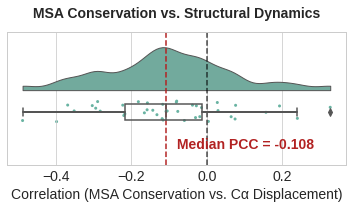

In [16]:
# --- EXECUTION ---
PER_GPCR_CORR_FILE = "../Output/Dynamics/Correlation_Per_GPCR.csv"
FIG2D_FILE = "../Output/Dynamics/Figure2d_Conservation_vs_Dynamics.png"
plot_2d_raincloud(PER_GPCR_CORR_FILE, FIG2D_FILE)